# Thoracic and Abdominal Breathing during Repetitive Tasks

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as si
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import neurokit2 as nk
from dtw import dtw, accelerated_dtw
import emd
import glob
import os

sns.set()

## Import data

In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), '/Users/luissilva/PycharmProjects/PhysioOper/data', "*.txt"))
file_list = np.sort(file_list)
print(file_list)

data = []

for file_path in file_list:
    load = np.loadtxt(file_path)
    data.append(load)

info = []

for file_path in file_list:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        info.append(lines[1][19:21])

['/Users/luissilva/PycharmProjects/PhysioOper/data/S02_REST_POS_2021-11-11_17-41-17.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_REST_PRE_2021-11-11_16-17-24.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task1_2021-11-05_15-52-46.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task2_2021-11-05_16-13-59.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task3_2021-11-05_16-37-44.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_REST_POS_2021-11-11_13-06-56.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_REST_PRE_2021-11-11_11-15-07.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK1_2021-11-11_12-19-12.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK2_2021-11-11_12-35-07.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK3_2021-11-11_12-55-04.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S04_REST_POS_2021-11-11_17-41-17.txt'
 '/Users/luissilva/PycharmProjects/Phys

## Prepare data

In [3]:
id_value = 200000

for ii in range(0, len(data)):
    if len(data[ii]) > 200000:
        data[ii] = data[ii][len(data[ii]) - 570000 - 20000: -20000, :]
    else:
        data[ii] = data[ii][-120000:, :]

resp_data = []

for ii in range(0, len(data)):
    if info[ii] == 'AD':
        resp = np.array([data[ii][:, 7], data[ii][:, 8]])
        resp_data.append(resp)
    elif info[ii] == 'DC':
        resp = np.array([data[ii][:, 16], data[ii][:, 17]])
        resp_data.append(resp)

## Filter data 

In [5]:
filtered_resp = resp_data.copy()
col = resp_data[1].shape[0]

for ii in range(0, len(filtered_resp)):
    for jj in range(0, col):
        filtered_resp[ii][jj, :] = nk.signal_filter(resp_data[ii][jj, :], lowcut=0.15, highcut=.45,
                                                  method='fir', order=5)

## Downsample data

In [6]:
ds_resp = []

for ii in range(0, len(filtered_resp)):
    ds = filtered_resp[ii][:, ::25]
    ds_resp.append(ds)

In [7]:
ds_resp[1].shape

(2, 4800)

## Signal decomposition

In [8]:
comp_resp = []

for ii in range(0, len(ds_resp)):
    for jj in range(0, col):
        imf_resp = emd.sift.ensemble_sift(ds_resp[ii][jj, :], max_imfs=5)
        comp_resp.append(imf_resp)

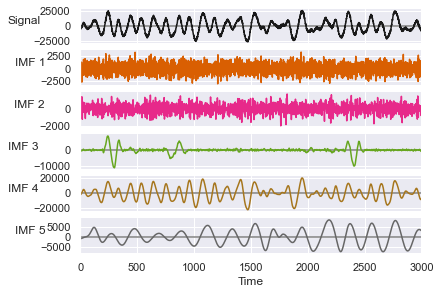

In [9]:
emd.plotting.plot_imfs(comp_resp[4][5000:8000, :], cmap=True)

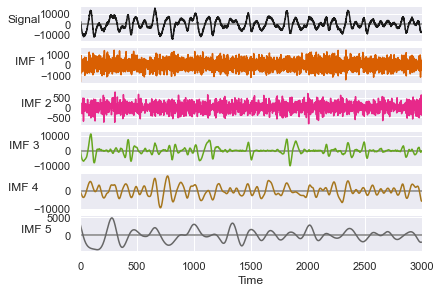

In [10]:
emd.plotting.plot_imfs(comp_resp[18][5000:8000, :], cmap=True)

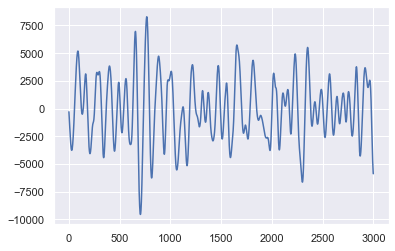

In [11]:
plt.plot(comp_resp[18][5000:8000, 3])

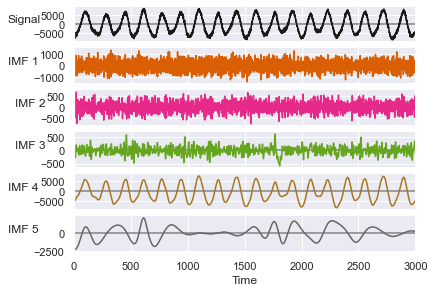

In [12]:
emd.plotting.plot_imfs(comp_resp[2][1000:4000, :], cmap=True)

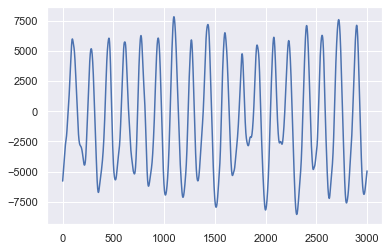

In [13]:
plt.plot(comp_resp[2][1000:4000,3])

## Normalization

In [14]:
# Signal itself

z_ds_resp = ds_resp.copy()

for ii in range(0, len(ds_resp)):
    for jj in range(0, col):
        z_ds_resp[ii][jj, :] = (ds_resp[ii][jj, :] - np.mean(ds_resp[ii][jj, :])) / np.std(ds_resp[ii][jj, :])
        
# Reconstructed signal of the decomposition

z_comp_resp = comp_resp.copy()

for ii in range(0, len(comp_resp)):
    for jj in range(0, 5):
        z_comp_resp[ii][jj, :] = (comp_resp[ii][jj, :] - np.mean(comp_resp[ii][jj, :])) / np.std(comp_resp[ii][jj, :])

## Synchronization

#### The synchronization analysis comprises four different methods: 1) Pearson coefficient in segmented and overlapping window; 2) Cross correlation; 3) Dynamic time warping; 4) Instantaneous phase.

### Pearson coefficient with overlapping window

In [15]:
def smooth(y, win_size):
    window = np.ones(win_size) / win_size
    y_smooth = np.convolve(y, window, mode='same')

    return y_smooth

# Signal itself

cor = []
center=False

for ii in range(0, len(ds_resp)):
    s = nk.signal_synchrony(z_ds_resp[ii][0, :], z_ds_resp[ii][1, :], method="correlation", window_size=100)
    cor.append(s)    

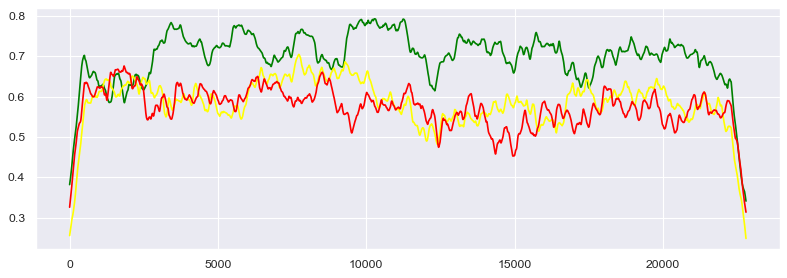

In [75]:

tasks = [ii for ii in range(len(info)) if ii % 5 == 2]

green_i = []
yellow_i = []
red_i = []

for n in tasks:
    g = cor[n]
    green_i.append(g)
    y = cor[n+1]
    yellow_i.append(y)
    r = cor[n+2]
    red_i.append(r)

green = np.mean(green_i, axis=0)
yellow = np.mean(yellow_i, axis=0)
red = np.mean(red_i, axis=0)

plt.figure(figsize=(12, 4), dpi=80)
plt.plot(smooth(green, 1000), color='green')
plt.plot(smooth(yellow, 1000), color='yellow')
plt.plot(smooth(red, 1000), color='red')

### Cross-correlation

In [29]:
# Signal itself

xcor = np.zeros((len(z_ds_resp), 1))
xlag = np.zeros((len(z_ds_resp), 1))

for n in range(0, len(ds_resp)):
    corr = si.correlate(z_ds_resp[n][0, :], z_ds_resp[n][1, :], mode='full', method='auto')
    lags = si.correlation_lags(len(z_ds_resp[n][0, :]), len(z_ds_resp[n][1, :]))
    corr /= np.max(corr)
    pos = np.argmax(corr)
    xcor[n] = np.max(corr)
    xlag[n] = len(corr) / 2 - pos
    
print(xlag.T)

[[  0.5  -0.5  -3.5 -16.5 -14.5   0.5   1.5   3.5   6.5   7.5   0.5  -0.5
   -1.5  -0.5   2.5  -6.5  -8.5   4.5   4.5   5.5]]


Text(0, 0.5, 'Samples')

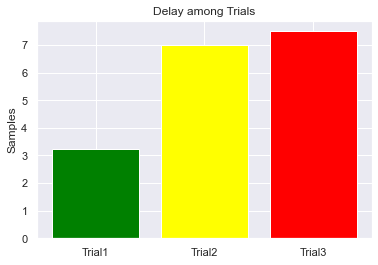

In [63]:
xlag = abs(xlag)

task1 = []
task2 = []
task3 = []

for n in tasks:
    t1 = xlag[n]
    task1.append(t1)
    t2 = xlag[n+1]
    task2.append(t2)
    t3 = xlag[n+2]
    task3.append(t3)

task1 = np.mean(task1)
task2 = np.mean(task2)
task3 = np.mean(task3)

plt.bar(['Trial1', 'Trial2', 'Trial3'], [task1, task2, task3], color=['green','yellow', 'red'])
plt.title('Delay among Trials')
plt.ylabel('Samples')

In [31]:
# Reconstructed signal of the decomposition

xcor_d = np.zeros((len(z_comp_resp), 1))
xlag_d = np.zeros((len(z_comp_resp), 1))

tasks = [ii for ii in range(len(z_comp_resp)) if ii % 2 == 0]

for n in tasks:
    corr = si.correlate(comp_resp[n][:, 3], comp_resp[n + 1][:, 3], mode='full', method='auto')
    lags = si.correlation_lags(len(comp_resp[n][:, 3]), len(comp_resp[n + 1][:, 3]))
    corr /= np.max(corr)
    pos = np.argmax(corr)
    xcor_d[n] = np.max(corr)
    xlag_d[n] = len(corr) / 2 - pos

xlag_d = xlag_d[xlag_d != 0]

[ 0.5  0.5  3.5 17.5 84.5  0.5  1.5  0.5  4.5  4.5  1.5  0.5  1.5  0.5
  4.5  7.5 11.5  6.5  4.5  5.5]


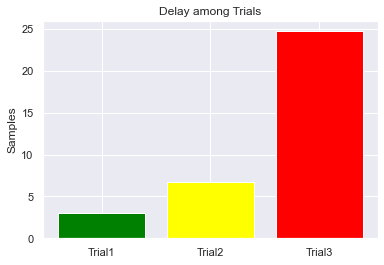

In [64]:
xlag_d = abs(xlag_d)

task1 = []
task2 = []
task3 = []

for n in tasks:
    t1 = xlag_d[n]
    task1.append(t1)
    t2 = xlag_d[n+1]
    task2.append(t2)
    t3 = xlag_d[n+2]
    task3.append(t3)

task1 = np.mean(task1)
task2 = np.mean(task2)
task3 = np.mean(task3)

plt.bar(['Trial1', 'Trial2', 'Trial3'], [task1, task2, task3], color=['green','yellow', 'red'])
plt.title('Delay among Trials')
plt.ylabel('Samples')

print(xlag_d)

### Instantaneous phase synchrony

#### In the following two methods the signal that will be used is converted by Hilbert-Huang transform. In this case, the reconstructed signal of the decomposition must be used.

In [70]:
phase_chest = []
phase_abd = []
phase_synchrony = []

tasks2 = [ii for ii in range(len(z_comp_resp)) if ii % 2 == 0]

for n in tasks2:
    y1 = comp_resp[n][:, 2] + comp_resp[n][:, 3]
    ph_chest = np.angle(si.hilbert(y1),deg=False)
    phase_chest.append(ph_chest)
    y2 = comp_resp[n + 1][:, 2] + comp_resp[n + 1][:, 3]
    ph_abd= np.angle(si.hilbert(y2),deg=False)
    phase_abd.append(ph_abd)

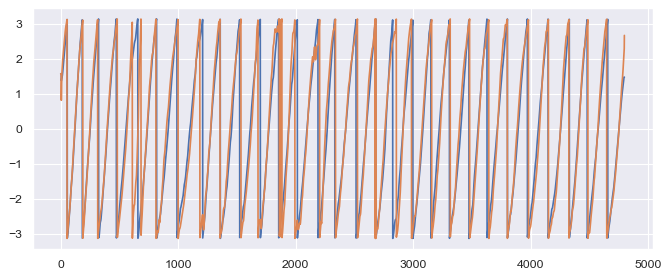

In [71]:
plt.figure(figsize=(10, 4), dpi=80)
plt.plot(phase_chest[1])
plt.plot(phase_abd[1])

In [76]:
for jj in range(0,len(phase_chest)):
    phase_diff = 1 - np.sin(np.abs(phase_chest[jj] - phase_abd[jj]) / 2)
    phase_synchrony.append(phase_diff)

[2, 7, 12, 17]

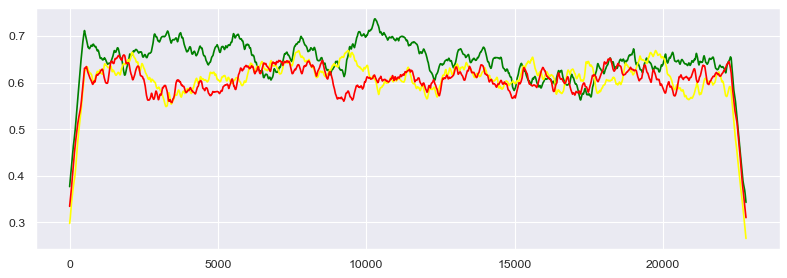

In [82]:
ph1 = []
ph2 = []
ph3 = []

for n in tasks:
    p1 = phase_synchrony[n]
    ph1.append(p1)
    p2 = phase_synchrony[n+1]
    ph2.append(p2)
    p3 = phase_synchrony[n+2]
    ph3.append(p3)

green = np.mean(ph1, axis = 0)
yellow = np.mean(ph2, axis = 0)
red = np.mean(ph3, axis = 0)
                 
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(smooth(green, 1000), 'green')
plt.plot(smooth(yellow, 1000), 'yellow')
plt.plot(smooth(red, 1000), 'red')

### Dynamic time warping

In [71]:
d = []
cost_matrix = []
acc_cost_matrix = []
path = []

for jj in range(0,len(phase_chest)):
    d_i, cost_matrix_i, acc_cost_matrix_i, path_i = accelerated_dtw(phase_chest[jj], phase_abd[jj], dist='euclidean')
    d.append(d_i)
    cost_matrix.append(cost_matrix_i)
    acc_cost_matrix.append(acc_cost_matrix_i)
    path.append(path_i)

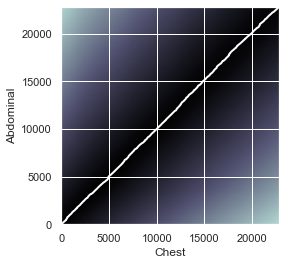

In [81]:
plt.figure()
plt.imshow(acc_cost_matrix[0].T, origin='lower', cmap='bone', interpolation='nearest')
plt.plot(path[0][0], path[0][1], 'w', linewidth=2)
plt.xlabel('Chest')
plt.ylabel('Abdominal')
plt.show()

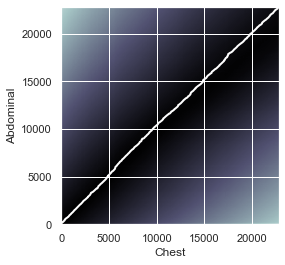

In [82]:
plt.figure()
plt.imshow(acc_cost_matrix[1].T, origin='lower', cmap='bone', interpolation='nearest')
plt.plot(path[1][0], path[1][1], 'w', linewidth=2)
plt.xlabel('Chest')
plt.ylabel('Abdominal')
plt.show()